In this notebook we use data from 10000 simulated trajectories of +10pN/s force ramps in an asymmetric double well potential. This is the same system analysed in Section IV C of the paper (arXiv:2511.09183), for a potential with Mutant-like parameters. 

Below, we demonstrate how the irreversibility is calculated from displacements classified into 4 types: crossing x=k left->right, crossing it right->left, staying left, staying right. We use the nearest neighbours estimator of KL-divergence from Q. Wang et al. (IEEE Vol. 55, No. 5, May 2009), adapted to our irreversibility measure, as explained in SM-IV of our work. This inference is done on the pure set of recorded positions (extensions) from simulations, and on another with added noise to this data, to simulate the experimental limitations.

In [59]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import KDTree

In [60]:
def rolling_std(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).std().to_numpy()
def rolling_average(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

In [61]:
# sort displacements into 4 classes with respect to boundary k
def sortDisplacements4idx(snapshots_x, i, f, k):
    """
    snapshots_x is a (time, N) array of trajectory snapshots
    i and f denote the start and end times for the displacements
    k is the boundary with respect to which displacements are categorized
    """
    disp1 = snapshots_x[f]-snapshots_x[i]
    dispCrossR, dispCrossL, dispBulkL, dispBulkR = [], [], [], []
    for idx, l in enumerate(disp1):
        if (snapshots_x[f][idx]>k and snapshots_x[i][idx]<k):
            dispCrossR.append([l,idx])
        elif (snapshots_x[f][idx]<k and snapshots_x[i][idx]>k):
            dispCrossL.append([l,idx])
        elif snapshots_x[f][idx]>k:
            dispBulkR.append([l,idx])
        else:
            dispBulkL.append([l,idx])
    dispCrossR, dispCrossL, dispBulkL, dispBulkR = np.array(dispCrossR), np.array(dispCrossL), np.array(dispBulkL), np.array(dispBulkR)       
    return dispCrossR, dispCrossL, dispBulkR, dispBulkL

# sort displacements into 3 classes with respect to boundary k
def sortDisplacements3idx(snapshots_x, i, f, k):
    disp1 = snapshots_x[f]-snapshots_x[i]
    dispCrossR, dispCrossL, dispBulk = [], [], []
    for idx, l in enumerate(disp1):
        if (snapshots_x[f][idx]>k and snapshots_x[i][idx]<k):
            dispCrossR.append([l,idx])
        elif (snapshots_x[f][idx]<k and snapshots_x[i][idx]>k):
            dispCrossL.append([l,idx])
        else:
            dispBulk.append([l,idx])
    dispCrossR, dispCrossL, dispBulk = np.array(dispCrossR), np.array(dispCrossL), np.array(dispBulk)     
    return dispCrossR, dispCrossL, dispBulk

In [62]:
# estimator for one term in the Dkl of marginal probabilities Eq. (14) and (A16)
def kl_div_single_trans(samples_p, samples_q, total_n, epsilon):
    """
    samples_p, samples_q are the lists of displacements in each class, from which their marginal probabilities are estimated as prob_p, prob_q
    total_n is the total number of displacements (and trajectories), necessary for normalisation
    epsilon is the regularisation parameter to avoid log divergences
    """
    prob_p, prob_q = len(samples_p)/total_n, len(samples_q)/total_n
    if prob_p==0:
        return 0.
    elif prob_q==0 and epsilon==0: # no regularisation for missing transition
        return 0.
    else:
        prob_q = epsilon/total_n if prob_q == 0 else prob_q
        return prob_p*np.log(prob_p/prob_q)

# calculates the Dkl trans from marginal probabilities of 4 displacement classes, but majorly contributing are those that cross the boundary k
# Eq. (A16) in Appendix A1a
def kl_trans(snapshots_x, t, k, Dt=1, epsilon=1e-1): 
    total_n = len(snapshots_x[0]) # total number of displacements

    # the time-forward displacements in the [t-dt, t] window
    samples_R, samples_L, samples_B = sortDisplacements3idx(snapshots_x, t-Dt, t, k)
    # the time-reverse displacements in the [t, t+dt] window
    samples_R2, samples_L2, samples_B2 = sortDisplacements3idx(snapshots_x, t, t+Dt, k)

    # get the displacements out
    if (len(samples_R)==0 and len(samples_L2)==0):
        samples_R, samples_L2, samples_R_idx, samples_L2_idx = [],[],[],[]
    elif (len(samples_R)==0 or len(samples_L2)==0):
        full = 1 if len(samples_R)==0 else 0
        samples_R_idx = samples_R[:,1].astype(int) if full==0 else []
        samples_L2_idx = samples_L2[:,1].astype(int) if full==1 else []
        samples_R = samples_R[:,0] if full==0 else []
        samples_L2 = -samples_L2[:,0] if full==1 else []
    else:    
        samples_R_idx, samples_L2_idx = samples_R[:,1].astype(int), samples_L2[:,1].astype(int)
        samples_R, samples_L2 = samples_R[:,0], -samples_L2[:,0] 
    if (len(samples_R2)==0 and len(samples_L)==0):
        samples_R2, samples_L, samples_R2_idx, samples_L_idx = [],[],[],[]
    elif (len(samples_R2)==0 or len(samples_L)==0):
        full = 1 if len(samples_R2)==0 else 0
        samples_R2_idx = samples_R2[:,1].astype(int) if full==0 else []
        samples_L_idx = samples_L[:,1].astype(int) if full==1 else []
        samples_R2 = -samples_R2[:,0] if full==0 else []
        samples_L = samples_L[:,0] if full==1 else []
    else:    
        samples_R2_idx, samples_L_idx = samples_R2[:,1].astype(int), samples_L[:,1].astype(int)
        samples_R2, samples_L = -samples_R2[:,0], samples_L[:,0]
    samples_B_idx, samples_B2_idx = samples_B[:,1].astype(int), samples_B2[:,1].astype(int)
    samples_B, samples_B2 = samples_B[:,0], -samples_B2[:,0]

    # Compute the full-sample KL divergence
    kl_div_R = kl_div_single_trans(samples_R, samples_L2, total_n, epsilon)
    kl_div_L = kl_div_single_trans(samples_L, samples_R2, total_n, epsilon)
    kl_div_B = kl_div_single_trans(samples_B, samples_B2, total_n, epsilon)
    
    full_kl_div = kl_div_R + kl_div_L + kl_div_B

    return full_kl_div

In [63]:
# estimator for one term (one class) in the mixed discrete-continuous joint probability distributions of displacements
# one term of Eq. (S30) in Supplementary Material
def kl_divergence_single_NN(NN, samples_p, samples_q, total_n, epsilon, n_thresh=2, m_thresh=1, NNmin=1, NNmax=10): # takes care of unidirectional transitions.. based on dx
    """
    NN is the number of nearest neighbours the estimator will use. If NN='auto' the number is selected according to the size of dataset
    NNmin and NNmax are the minimum and maximum NN that the 'auto' setting will allow.
    
    samples_p, samples_q are the lists of displacements in class p and its time-reverse q
    total_n is the total number of displacements (and trajectories) across all classes, necessary for normalisation
    
    if the number of displacements in p or q are below n_thresh and m_thresh, respectively, we reroute to the trans estimator (marginal probabilities)
    epsilon is the regularisation parameter to avoid log divergences in the trans estimator
    """
    
    n, m = len(samples_p), len(samples_q)
    if (n<n_thresh or m<m_thresh):
        return kl_div_single_trans(samples_p, samples_q, total_n, epsilon)
                
    samples_p = np.array([[a] for a in samples_p])
    samples_q = np.array([[a] for a in samples_q])
    n, m = len(samples_p), len(samples_q)
    if NN=='auto': # this is if you are not fixing NN and would like it to adapt to the size of the data (n, m) in the distributions
        NN = max(NNmin, min(NNmax,round(n**1/3),round(m**(1/3)))) 
        nu_d, nu_i = KDTree(samples_q).query(samples_p, NN)
        rho_d, rhio_i = KDTree(samples_p).query(samples_p, NN + 1)
        # KTree.query returns different shape in k==1 vs k > 1
        if NN > 1:
            D = (1 / n) * np.sum(np.log(nu_d[::, -1] / rho_d[::, -1]))
        else:
            D = (1 / n) * np.sum(np.log(nu_d / rho_d[::, -1]))
        kl_div = (D + np.log(n/(n - 1))) * n/total_n
    else:
        nu_d, nu_i = KDTree(samples_q).query(samples_p, NN)
        rho_d, rhio_i = KDTree(samples_p).query(samples_p, NN + 1)
        # KTree.query returns different shape in k==1 vs k > 1
        if NN > 1:
            D = (1 / n) * np.sum(np.log(nu_d[::, -1] / rho_d[::, -1]))
        else:
            D = (1 / n) * np.sum(np.log(nu_d / rho_d[::, -1]))
        kl_div = (D + np.log(n/(n - 1))) * n/total_n

    return kl_div

# calculates from the full array of snapshots, the irreversibility at time t, using C4 displacement classification with respect to k
# Eq. (A13) in Appendix A1a
def NN_kld_C4(snapshots_x, NN, t, k, Dt=1, epsilon=1e-10, n_thresh=2, m_thresh=1, NNmin=2, NNmax=10): # Nearest neighbour
    """
    snapshots_x is a (time, N) array of trajectory snapshots
    t is the time we wish to evaluate irreversibility at, an index of snapshots_x
    k is the displacement boundary
    Dt is the time-window, as a shift in index with respect to t, over which displacements are measured.
    Thereforce t-Dt and t+Dt must be accessible in the snaphsots_x array.
    
    NN is the number of nearest neighbours the estimator will use. If NN='auto' the number is selected according to the size of dataset
    NNmin and NNmax are the minimum and maximum NN that the 'auto' setting will allow.
    
    if, for a given estimation, the number of displacements in class p or its time-reverse q are below n_thresh and m_thresh, respectively, 
    we reroute to the trans estimator (marginal probabilities).
    epsilon is the regularisation parameter to avoid log divergences in the trans estimator
    """
    
    total_n = len(snapshots_x[0]) # total number of molecules, displacements

    # the time-forward displacements in the [t-dt, t] window
    samples_R, samples_L, samples_BulkR, samples_BulkL = sortDisplacements4idx(snapshots_x, t-Dt, t, k)
    # the time-reverse displacements in the [t, t+dt] window
    samples_R2, samples_L2, samples_BulkR2, samples_BulkL2 = sortDisplacements4idx(snapshots_x, t, t+Dt, k)
    
    # extract non-empty displacements (samples)
    if (len(samples_R)==0 and len(samples_L2)==0):
        samples_R, samples_L2, samples_R_idx, samples_L2_idx = [],[],[],[]
    elif (len(samples_R)==0 or len(samples_L2)==0):
        full = 1 if len(samples_R)==0 else 0
        samples_R_idx = samples_R[:,1].astype(int) if full==0 else []
        samples_L2_idx = samples_L2[:,1].astype(int) if full==1 else []
        samples_R = samples_R[:,0] if full==0 else []
        samples_L2 = -samples_L2[:,0] if full==1 else []
    else:    
        samples_R_idx, samples_L2_idx = samples_R[:,1].astype(int), samples_L2[:,1].astype(int)
        samples_R, samples_L2 = samples_R[:,0], -samples_L2[:,0] # flip the sign of the time-reverse displacements (k<-)
    if (len(samples_R2)==0 and len(samples_L)==0):
        samples_R2, samples_L, samples_R2_idx, samples_L_idx = [],[],[],[]
    elif (len(samples_R2)==0 or len(samples_L)==0):
        full = 1 if len(samples_R2)==0 else 0
        samples_R2_idx = samples_R2[:,1].astype(int) if full==0 else []
        samples_L_idx = samples_L[:,1].astype(int) if full==1 else []
        samples_R2 = -samples_R2[:,0] if full==0 else []
        samples_L = samples_L[:,0] if full==1 else []
    else:    
        samples_R2_idx, samples_L_idx = samples_R2[:,1].astype(int), samples_L[:,1].astype(int)
        samples_R2, samples_L = -samples_R2[:,0], samples_L[:,0] # flip the sign of the time-reverse displacements (k->)
    if (len(samples_BulkR)==0 and len(samples_BulkR2)==0):
        samples_BulkR, samples_BulkR2, samples_BulkR_idx, samples_BulkR2_idx = [],[],[],[]
    elif (len(samples_BulkR)==0 or len(samples_BulkR2)==0):
        full = 1 if len(samples_BulkR)==0 else 0
        samples_BulkR_idx = samples_BulkR[:,1].astype(int) if full==0 else []
        samples_BulkR2_idx = samples_BulkR2[:,1].astype(int) if full==1 else []
        samples_BulkR = samples_BulkR[:,0] if full==0 else []
        samples_BulkR2 = -samples_BulkR2[:,0] if full==1 else []
    else:    
        samples_BulkR_idx, samples_BulkR2_idx = samples_BulkR[:,1].astype(int), samples_BulkR2[:,1].astype(int)
        samples_BulkR, samples_BulkR2 = samples_BulkR[:,0], -samples_BulkR2[:,0] # flip the sign of the time-reverse displacements (Br)
    if (len(samples_BulkL)==0 and len(samples_BulkL2)==0):
        samples_BulkL, samples_BulkL2, samples_BulkL_idx, samples_BulkL2_idx = [],[],[],[]
    elif (len(samples_BulkL)==0 or len(samples_BulkL2)==0):
        full = 1 if len(samples_BulkL)==0 else 0
        samples_BulkL_idx = samples_BulkL[:,1].astype(int) if full==0 else []
        samples_BulkL2_idx = samples_BulkL2[:,1].astype(int) if full==1 else []
        samples_BulkL = samples_BulkL[:,0] if full==0 else []
        samples_BulkL2 = -samples_BulkL2[:,0] if full==1 else []
    else:    
        samples_BulkL_idx, samples_BulkL2_idx = samples_BulkL[:,1].astype(int), samples_BulkL2[:,1].astype(int)
        samples_BulkL, samples_BulkL2 = samples_BulkL[:,0], -samples_BulkL2[:,0] # flip the sign of the time-reverse displacements (Bl)

    kl_div_R = kl_divergence_single_NN(NN, samples_R, samples_L2, total_n, epsilon, n_thresh, m_thresh, NNmin, NNmax)
    kl_div_L = kl_divergence_single_NN(NN, samples_L, samples_R2, total_n, epsilon, n_thresh, m_thresh, NNmin, NNmax)
    kl_div_BulkR = kl_divergence_single_NN(NN, samples_BulkR, samples_BulkR2, total_n, epsilon, n_thresh, m_thresh, NNmin, NNmax)
    kl_div_BulkL = kl_divergence_single_NN(NN, samples_BulkL, samples_BulkL2, total_n, epsilon, n_thresh, m_thresh, NNmin, NNmax)
        
    # the full result of Eq. (S30)
    full_kl_div = kl_div_R + kl_div_L + kl_div_BulkL + kl_div_BulkR

    return full_kl_div

In [43]:
# load up the trajectories
x_snapshots=np.load("sample_rampTrajectories_float32.npy")
x_snapshots_noise = x_snapshots + np.random.normal(loc=0, scale=3, size=x_snapshots.shape) # add measurement noise to the positions

print(np.shape(x_snapshots))

dt = 0.001 # 1/ms is the frequency at which the simulated trajectories are sampled
time = np.arange(0, 1.6+dt, dt) 

(1601, 10000)


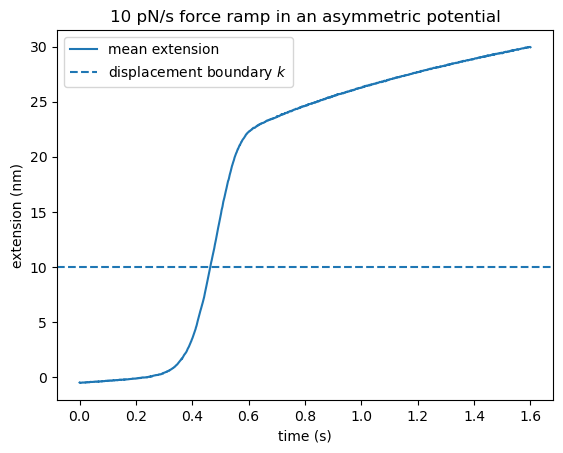

In [37]:
k = 10

plt.plot(time, np.mean(x_snapshots, axis=-1), label="mean extension")
plt.axhline(k, ls='dashed', label=r"displacement boundary $k$")
plt.xlabel("time (s)")
plt.ylabel("extension (nm)")
plt.legend()
plt.title("10 pN/s force ramp in an asymmetric potential")
plt.show()

In [34]:
%%time

Δt = 5 # 5ms is the time window over which displacements are measured for estimating irreversibility
dt = 1 # 1/ms frequency of irreversibility measurement

Σ4 = [] # irreversibility with 4 displacement classes
Σ4_noise = [] # irreversibility with 4 displacement classes, where noise is added to positions

e = 0 #  e/N regularization of missing transitions in the ΣTrans to avoid log divergences. If e=0 the estimator returns zero

#evaluate irreversibility during every window of Δt
for t in range(Δt, len(time)-Δt, dt):
    Σ4.append(NN_kld_C4(x_snapshots, 'auto', t, k, Dt=Δt, epsilon=e, n_thresh=3, m_thresh=3, NNmin=1, NNmax=10))
    Σ4_noise.append(NN_kld_C4(x_snapshots_noise, 'auto', t, k, Dt=Δt, epsilon=e, n_thresh=3, m_thresh=3, NNmin=1, NNmax=10))
Σ4, Σ4_noise = np.array(Σ4), np.array(Σ4_noise)
Σ4_dot, Σ4_dot_noise = Σ4/Δt/0.001, Σ4_noise/Δt/0.001 # irreversibility rate at each time

CPU times: total: 14min 12s
Wall time: 29min 50s


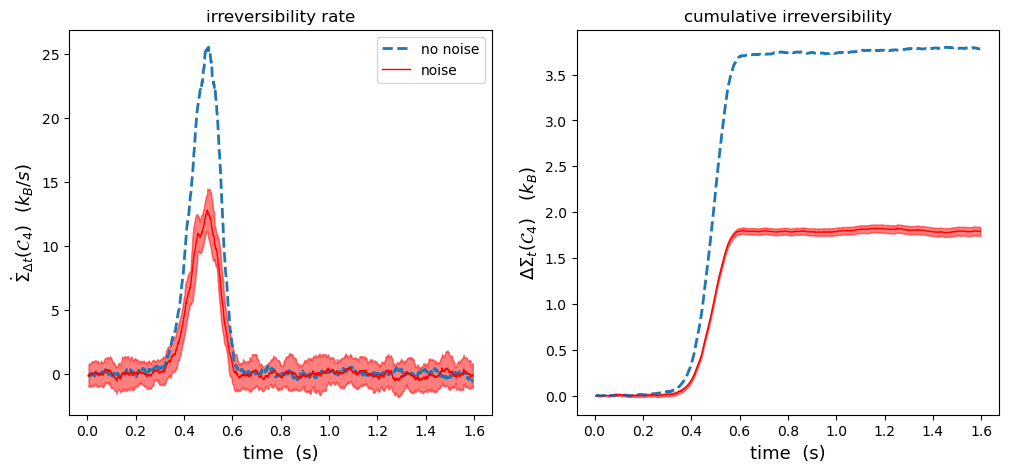

In [35]:
window = 30 # time window (ms) over which the irreversibility rate is smoothed
fs = 13 # label fontsize

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# irreversibiity rate
plt.plot(time[Δt:-Δt], rolling_average(Σ4_dot, int(window)), label="no noise", lw=2, ls='dashed')

Σ4_dot_noise_smooth = rolling_average(Σ4_dot_noise, int(window))
error = rolling_std(Σ4_dot_noise, int(window)) # error for the noisy estimate
plt.plot(time[Δt:-Δt], Σ4_dot_noise_smooth, label="noise", lw=1, color='red')
lower_bound = Σ4_dot_noise_smooth - error
upper_bound = Σ4_dot_noise_smooth + error
plt.fill_between(time[Δt:-Δt], lower_bound, upper_bound, alpha=0.5, interpolate=True, color='red')
plt.legend()
plt.ylabel(r"$\dot\Sigma_{\Delta t}(\mathcal{C}_4)$  ($k_B/s$)", fontsize=fs)
plt.xlabel("time  (s)", fontsize=fs)
plt.title('irreversibility rate')

plt.subplot(1,2,2)
# cumulative irreversibility
plt.plot(time[Δt:-Δt], np.cumsum(Σ4)/Δt, label="no noise", lw=2, ls='dashed')
plt.plot(time[Δt:-Δt], np.cumsum(Σ4_noise)/Δt, label="noise", lw=1, color='red')
lower_bound = np.cumsum(Σ4_noise)/Δt - np.sqrt(np.cumsum(error**2))*0.001
upper_bound = np.cumsum(Σ4_noise)/Δt + np.sqrt(np.cumsum(error**2))*0.001
plt.fill_between(time[Δt:-Δt], lower_bound, upper_bound, alpha=0.5, interpolate=True, color='red')

plt.ylabel(r"$\Delta\Sigma_{t}(\mathcal{C}_4)$   ($k_B$)", fontsize=fs)
plt.xlabel("time  (s)", fontsize=fs)
plt.title('cumulative irreversibility')
plt.show()